# Jimmy Liang
## SJSU 001869817
## CMPE 258 - HW3 - Part B1
## PyTorch - No auto differentiation 


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import torch


## Helper Classes

In [48]:
# 3D plot function

def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  from sklearn.manifold import TSNE

  tsne = TSNE(n_components=2, random_state=0)
  x_2d = tsne.fit_transform(x)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x_2d[:, 0], x_2d[:, 1], y, label='underlying function')
  if y_pred is not None:
    ax.scatter(x_2d[:, 0], x_2d[:, 1], y_pred, label='our function')
  plt.legend()

In [49]:
# Linear class

class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = torch.rand(input_dim, num_hidden)
    self.bias = torch.zeros(num_hidden,)

  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = torch.mm(torch.transpose(self.x,0,1), gradient)
    self.bias_gradient = gradient.sum(0)
    self.x_gradient = torch.mm(gradient, torch.transpose(self.weights,0,1))
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient


In [50]:
# MSE

class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return torch.mean((y_pred - y_true) ** 2)

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    return self.gradient


In [51]:
# Relu function

class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = torch.clamp(self.input_, min=0, out=None)
        return self.output
    
    def backward(self, output_gradient):
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient

relu = Relu()

In [52]:
class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden, 2)
  
  def __call__(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2
  
  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu_gradient = self.relu.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu_gradient)
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

In [53]:
# Fit function
from typing import Callable
def fit(x , y, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    if epoch % 5 == 0:
      print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

## Generating test data

x: torch.Size([100, 3]), weights: torch.Size([3, 2]), bias: torch.Size([2]), y: torch.Size([100, 2])


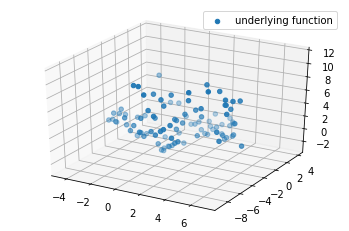

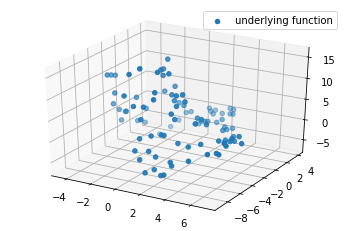

In [54]:
n = 100
d = 3
x = torch.FloatTensor(n, d).uniform_(-1, 1)
input_dim = d
output_dim = 2
learning_rate = 0.01 

weights_true = torch.tensor([[5, -1, 3], [1 , 8 , -3]]).float()
weights_true = torch.transpose(weights_true, 0, 1)
bias_true = torch.tensor([0.5, 1])
y_true = torch.mm(x**2, weights_true) + torch.mm(x, weights_true) + bias_true

print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

plot_3d(x, y_true[:,0])
plot_3d(x, y_true[:,1])

##Running the model

Loss Value:  tensor(18.8163)


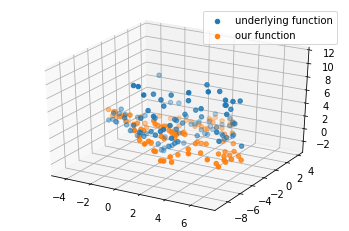

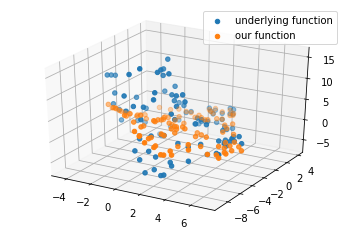

In [55]:
# Running the model for 1 cycle

loss = MSE()
model = Model(d, 10)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
loss_gradient = loss.backward()
print('Loss Value: ', loss_value)
model.backward(loss_gradient)
plot_3d(x, y_true[:,0], y_pred[:,0])
plot_3d(x, y_true[:,1], y_pred[:,1])

Epoch 0, loss 18.81631851196289
Epoch 5, loss 15.035938262939453
Epoch 10, loss 12.8845796585083
Epoch 15, loss 11.265227317810059
Epoch 20, loss 9.737866401672363
Epoch 25, loss 8.268017768859863
Epoch 30, loss 6.901825428009033
Epoch 35, loss 5.7116875648498535
Epoch 40, loss 4.748286247253418
Epoch 45, loss 4.0100202560424805
Epoch 50, loss 3.467761754989624
Epoch 55, loss 3.084324359893799
Epoch 60, loss 2.8122735023498535
Epoch 65, loss 2.611024856567383
Epoch 70, loss 2.4542312622070312
Epoch 75, loss 2.3321967124938965
Epoch 80, loss 2.2322263717651367
Epoch 85, loss 2.147172212600708
Epoch 90, loss 2.071135997772217
Epoch 95, loss 2.0009074211120605
Epoch 100, loss 1.9368666410446167
Epoch 105, loss 1.877946376800537
Epoch 110, loss 1.822678565979004
Epoch 115, loss 1.7710630893707275
Epoch 120, loss 1.723176121711731
Epoch 125, loss 1.677278757095337
Epoch 130, loss 1.6312557458877563
Epoch 135, loss 1.58632230758667
Epoch 140, loss 1.5420520305633545
Epoch 145, loss 1.5000306

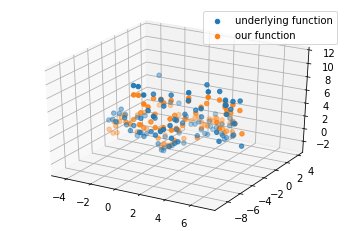

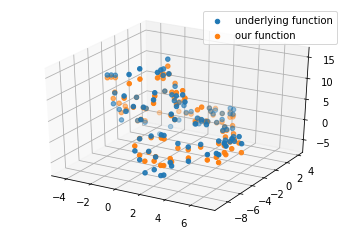

In [56]:
# Running the fit function, over 160 epochs

fit(x, y_true, model=model, loss=loss, lr=learning_rate, num_epochs=160)
y_pred = model(x)
plot_3d(x, y_true[:,0], y_pred[:,0])
plot_3d(x, y_true[:,1], y_pred[:,1])